MAD Statistics

In [99]:
#Place MAD data into SBS groups
# Import Modules
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
from scipy.io import loadmat
import scipy
from scipy.stats import ttest_ind, skew, ttest_rel
import Actigraph_Metrics
from pathlib import Path
import itertools


In [100]:
#data_dir = 'C:/Users/sidha/OneDrive/Sid_stuff/PROJECTS/PedAccel/data_analysis/Vitals_accel_analysis/PatientData'
data_dir = Path('/Users/jakehoffmann/Documents/JHU_Research/DT 6 Sedation/Ventilated_Patient_Data')
data_dir = Path('/Users/jakehoffmann/Documents/JHU_Research/DT 6 Sedation/PatientData_Directory_To_Have_NEW 3')
window_size = 100 #100 is 1 second worth of time
lead_time = 1
slice_size_min = 16
sr = .5
Tag = 'Retro'

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mannwhitneyu, kruskal, wilcoxon, ks_2samp, anderson

# Cohen's d
def cohens_d(x, y):
    diff = np.mean(x) - np.mean(y)
    pooled_std = np.sqrt((np.var(x, ddof=1) + np.var(y, ddof=1)) / 2)
    return diff / pooled_std if pooled_std > 0 else np.nan

# Hedges' g
def hedges_g(x, y):
    d = cohens_d(x, y)
    n1, n2 = len(x), len(y)
    correction_factor = 1 - (3 / (4*(n1+n2-2) - 1))
    return d * correction_factor

# Helper: plot when significant
def plot_difference(data_1, data_2, label_1, label_2, title_suffix=""):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram comparison
    axs[0].hist(data_1, bins=40, alpha=0.6, label=label_1)
    axs[0].hist(data_2, bins=40, alpha=0.6, label=label_2)
    axs[0].set_title(f"Histogram {title_suffix}")
    axs[0].legend()

    # Boxplot comparison
    axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])
    axs[1].set_title(f"Boxplot {title_suffix}")

    plt.tight_layout()
    plt.show()

def compare_data(data_1, label_1, data_2, label_2):
    data_1 = np.asarray(data_1)
    data_2 = np.asarray(data_2)

    # Must have data
    if data_1.size == 0 or data_2.size == 0:
        return []

    # Minimum sample size
    MIN_N = 30
    if len(data_1) < MIN_N or len(data_2) < MIN_N:
        return []

    # Subsample for statistical stability
    MAX_N = 500
    if len(data_1) > MAX_N:
        data_1 = np.random.choice(data_1, MAX_N, replace=False)
    if len(data_2) > MAX_N:
        data_2 = np.random.choice(data_2, MAX_N, replace=False)

    # Skip constant arrays
    if np.std(data_1) == 0 or np.std(data_2) == 0:
        return []

    significant_differences = []
    should_plot = False
    plot_title = ""

    # PRIMARY TESTS (keep these):
    
    # 1. Mann-Whitney U (Essential) - Best for your use case
    stat, p_value = mannwhitneyu(data_1, data_2, alternative='two-sided')
    if p_value < 0.05:
        significant_differences.append(f"Mann-Whitney U: p={p_value:.3e}")
        should_plot = True
        plot_title += f"MWU p={p_value:.1e}  "

    # 2. KS Test (Keep) - Good for detecting distributional differences
    stat, p_value = ks_2samp(data_1, data_2)
    if p_value < 0.05:
        significant_differences.append(f"KS test: p={p_value:.3e}")
        should_plot = True
        plot_title += f"KS p={p_value:.1e}  "

    # 3. Effect Size - Hedges' g (Keep) - Better for unequal sample sizes
    g = hedges_g(data_1, data_2)
    if np.isfinite(g) and abs(g) > 0.2:  # Lower threshold for clinical relevance
        significant_differences.append(f"Hedges' g: {g:.3f}")
        should_plot = True
        plot_title += f"g={g:.2f}  "

    # REMOVE THESE (redundant or inappropriate):
    # - Kruskal-Wallis (redundant with Mann-Whitney for 2 groups)
    # - Wilcoxon (requires paired data, which you don't have)
    # - Anderson-Darling (normality check not needed since we're using non-parametric tests)
    # - Cohen's d (use Hedges' g instead for better small sample correction)

    # ADD THESE FOR CLINICAL RELEVANCE:
    
    # 4. Median Difference with Confidence Intervals
    median_diff = np.median(data_1) - np.median(data_2)
    # Bootstrap CI for median difference
    n_boot = 1000
    boot_diffs = []
    for _ in range(n_boot):
        boot1 = np.random.choice(data_1, size=len(data_1), replace=True)
        boot2 = np.random.choice(data_2, size=len(data_2), replace=True)
        boot_diffs.append(np.median(boot1) - np.median(boot2))
    
    ci_low, ci_high = np.percentile(boot_diffs, [2.5, 97.5])
    significant_differences.append(f"Median diff: {median_diff:.3f} (95% CI: [{ci_low:.3f}, {ci_high:.3f}])")

    # 5. Probability of Superiority (Common Language Effect Size)
    # What's the probability that a random sample from group1 > random sample from group2?
    count_superior = 0
    n_comparisons = min(1000, len(data_1) * len(data_2))  # Limit for performance
    for _ in range(n_comparisons):
        if np.random.choice(data_1) > np.random.choice(data_2):
            count_superior += 1
    prob_superiority = count_superior / n_comparisons
    significant_differences.append(f"P(Superiority): {prob_superiority:.3f}")

    # --- Visualization Trigger ---
    if should_plot:
        print(f"Significant differences found for {label_1} vs {label_2}:")
        for diff in significant_differences:
            print(f"  - {diff}")
        plot_difference(data_1, data_2, label_1, label_2, plot_title)

    return significant_differences


skipping patient Patient15 due to load error.
Significant differences found for sbs -2 HR vs sbs -1 HR:
  - Mann-Whitney U: p=4.467e-06
  - KS test: p=4.977e-15
  - Hedges' g: 0.311
  - Median diff: 18.500 (95% CI: [12.988, 23.000])
  - P(Superiority): 0.579


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


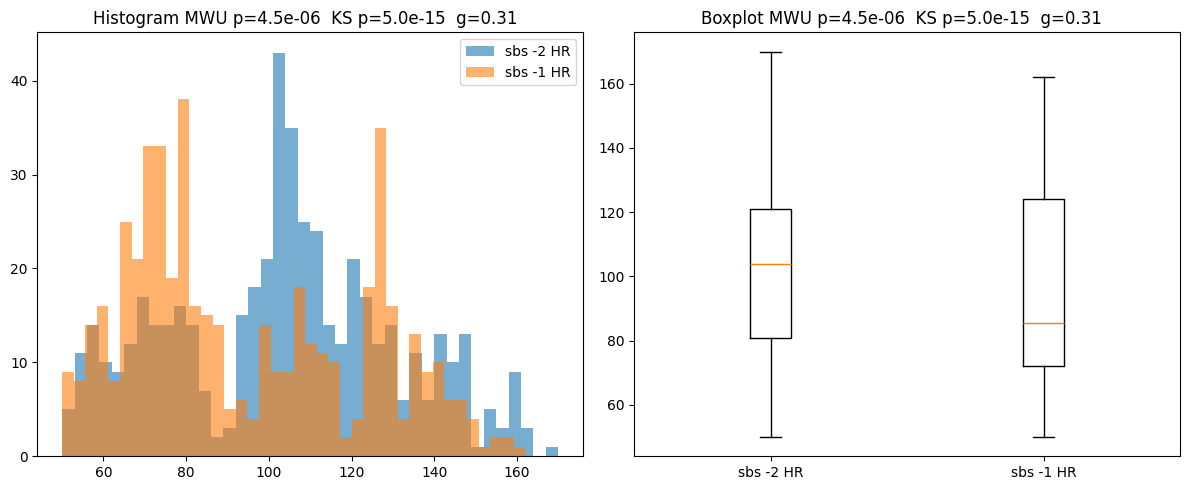

Significant differences found for sbs -2 HR vs sbs 0 HR:
  - Mann-Whitney U: p=2.806e-21
  - KS test: p=5.516e-20
  - Hedges' g: -0.601
  - Median diff: -14.000 (95% CI: [-17.000, -12.000])
  - P(Superiority): 0.306


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


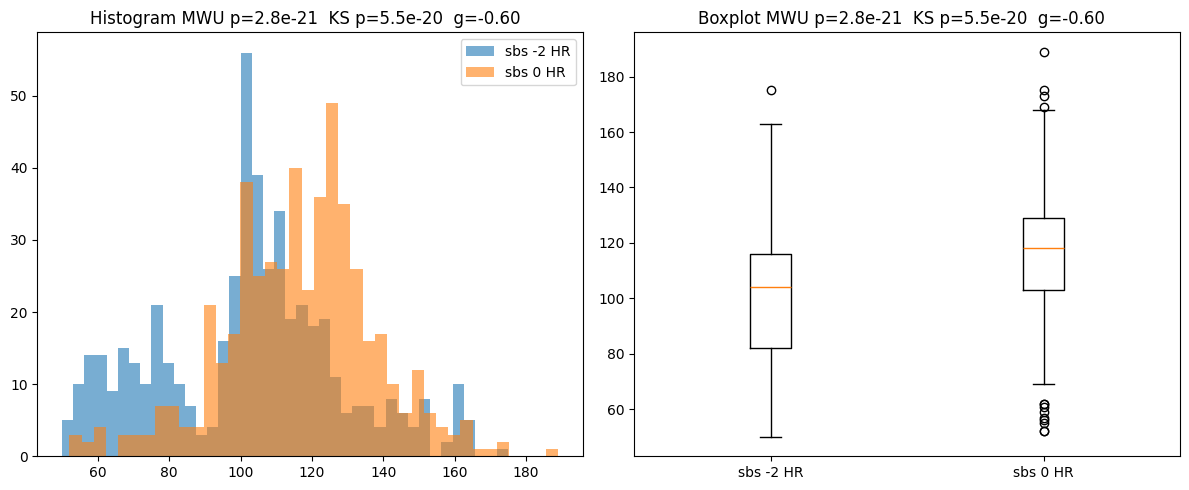

Significant differences found for sbs -2 HR vs sbs 1 HR:
  - Mann-Whitney U: p=6.111e-36
  - KS test: p=5.736e-46
  - Hedges' g: -0.861
  - Median diff: -17.000 (95% CI: [-20.000, -16.000])
  - P(Superiority): 0.256


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


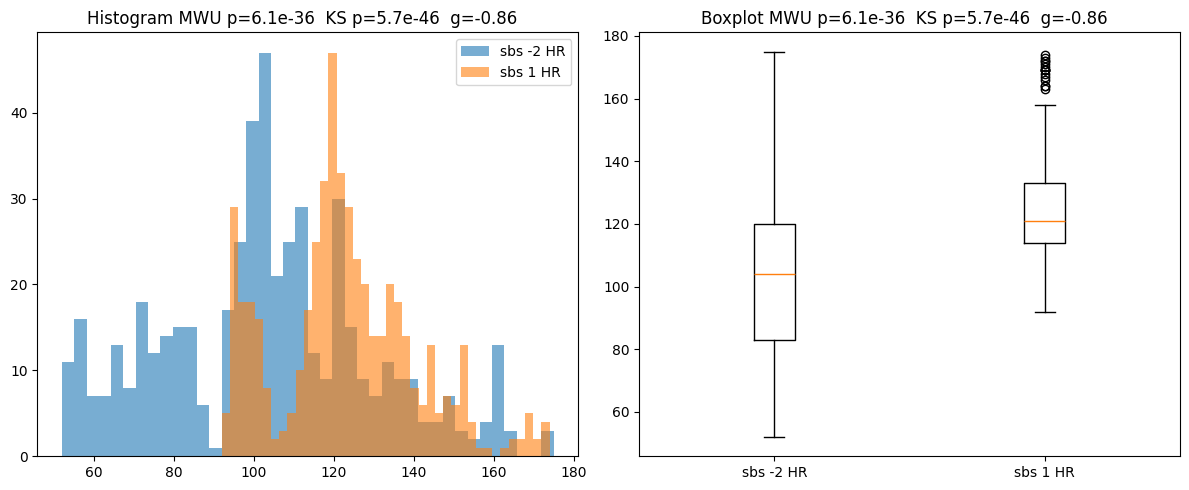

Significant differences found for sbs -1 HR vs sbs 0 HR:
  - Mann-Whitney U: p=6.112e-33
  - KS test: p=2.856e-42
  - Hedges' g: -0.864
  - Median diff: -30.000 (95% CI: [-34.000, -22.500])
  - P(Superiority): 0.279


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


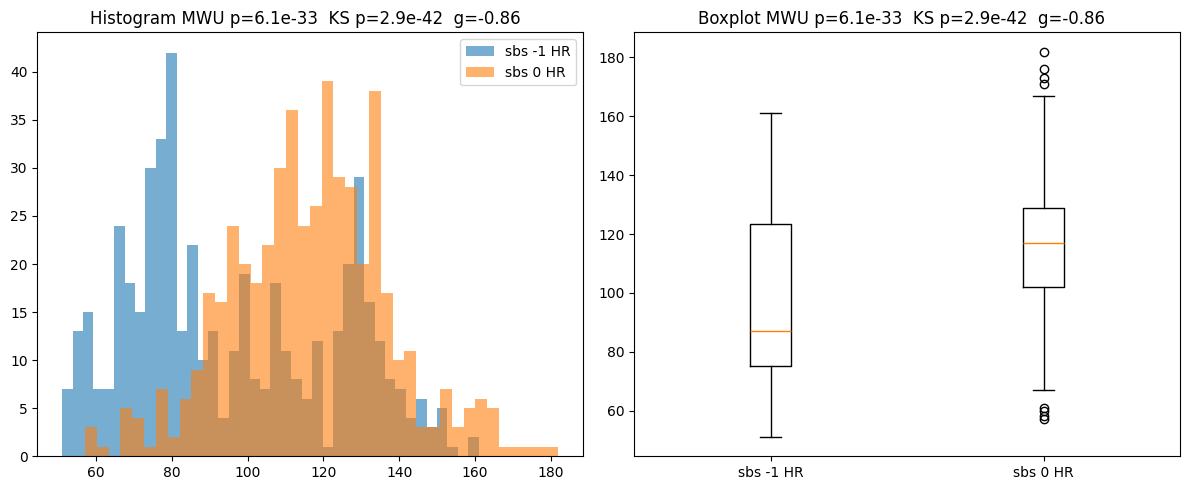

Significant differences found for sbs -1 HR vs sbs 1 HR:
  - Mann-Whitney U: p=1.195e-49
  - KS test: p=2.720e-69
  - Hedges' g: -1.217
  - Median diff: -33.000 (95% CI: [-39.000, -29.000])
  - P(Superiority): 0.237


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


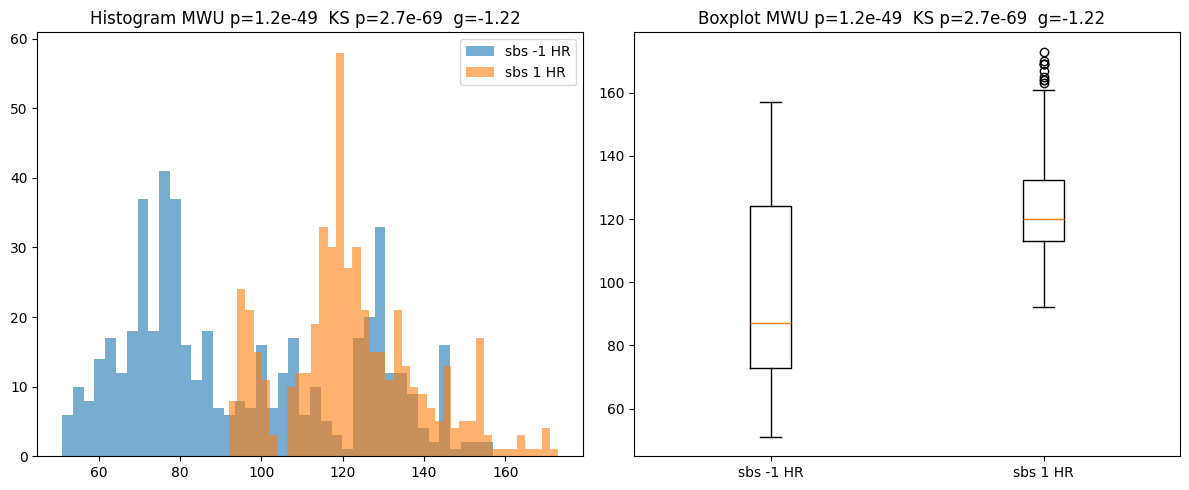

Significant differences found for sbs 0 HR vs sbs 1 HR:
  - Mann-Whitney U: p=8.962e-04
  - KS test: p=7.102e-07
  - Hedges' g: -0.233
  - Median diff: -3.000 (95% CI: [-5.500, -1.000])
  - P(Superiority): 0.412


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


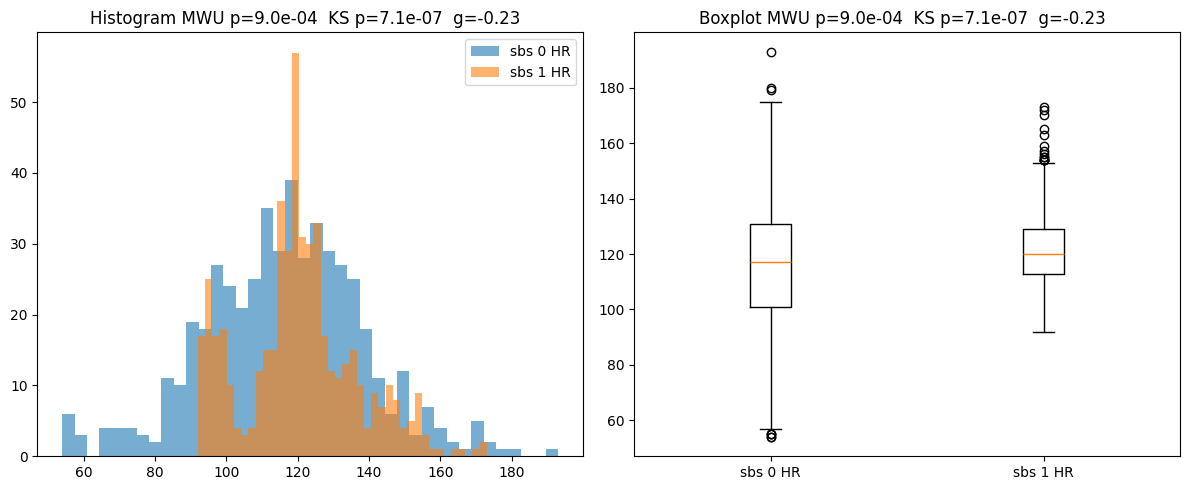

Significant differences found for sbs -2 RR vs sbs -1 RR:
  - Mann-Whitney U: p=1.131e-03
  - KS test: p=2.107e-11
  - Hedges' g: 0.212
  - Median diff: 3.000 (95% CI: [2.000, 3.000])
  - P(Superiority): 0.519


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


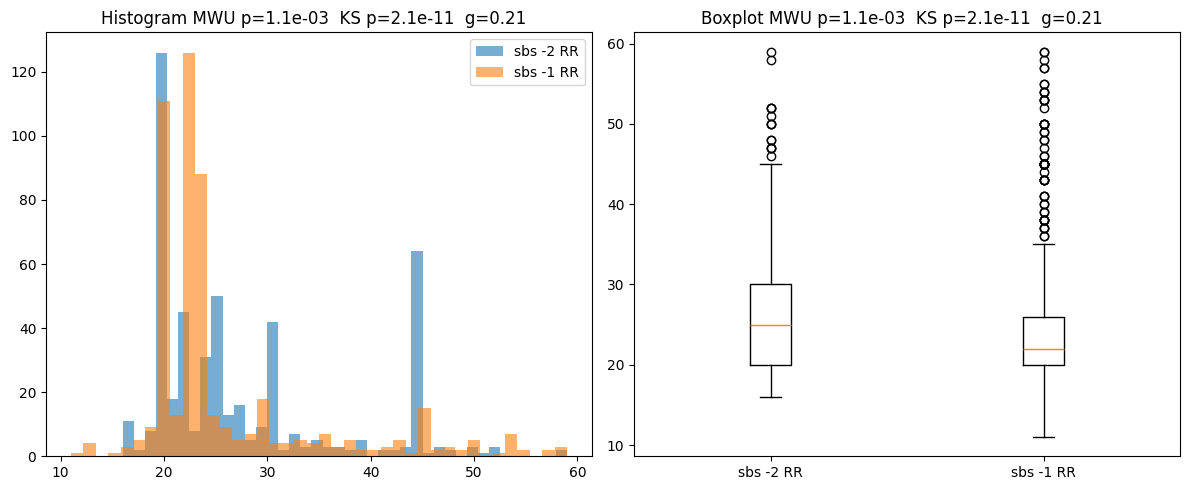

Significant differences found for sbs -2 RR vs sbs 0 RR:
  - Mann-Whitney U: p=1.715e-06
  - KS test: p=8.101e-11
  - Hedges' g: -0.242
  - Median diff: -3.000 (95% CI: [-5.000, -2.000])
  - P(Superiority): 0.376


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


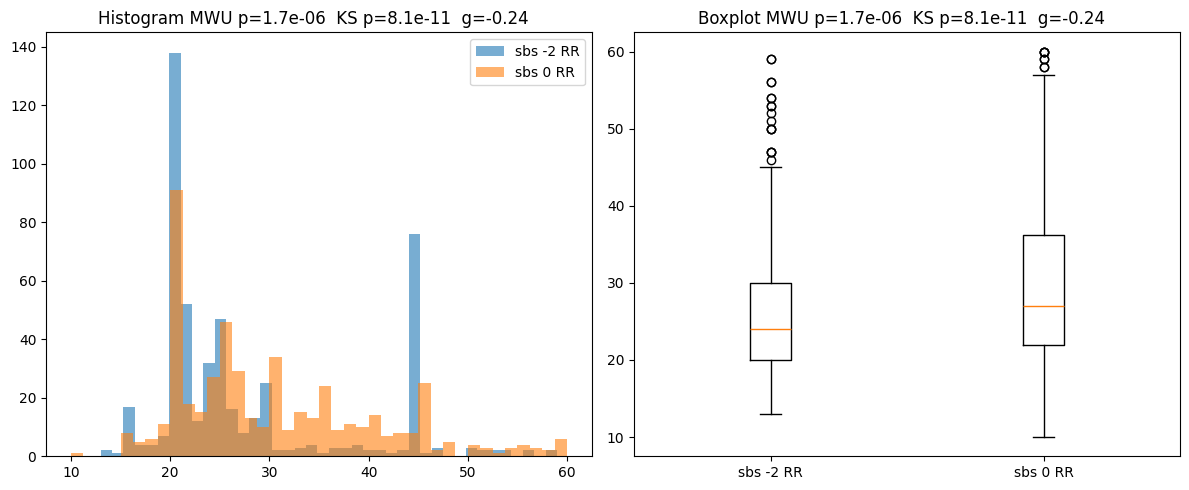

Significant differences found for sbs -2 RR vs sbs 1 RR:

/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])



  - Mann-Whitney U: p=8.835e-34
  - KS test: p=2.162e-35
  - Hedges' g: -0.771
  - Median diff: -10.000 (95% CI: [-12.000, -9.000])
  - P(Superiority): 0.278


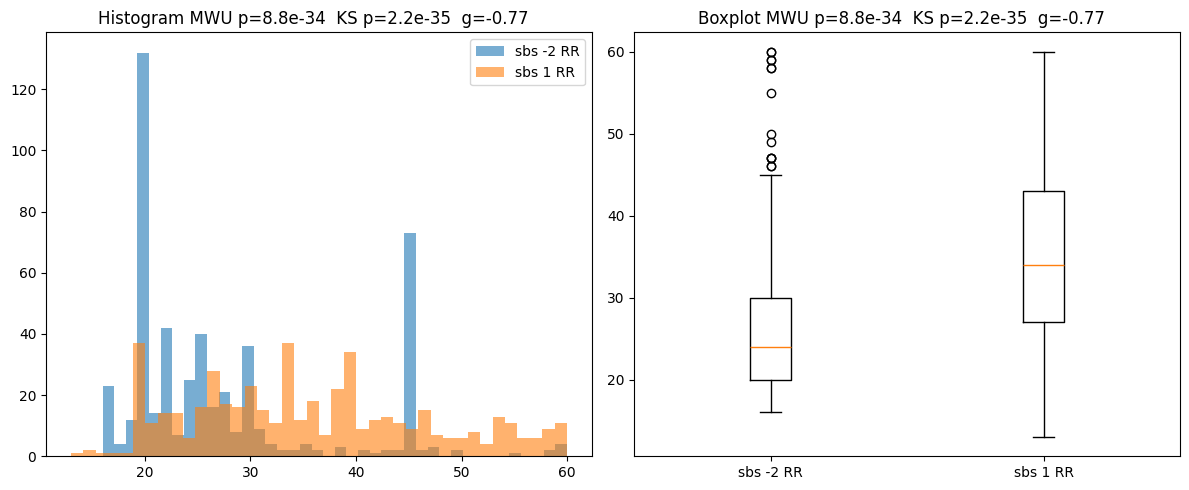

Significant differences found for sbs -1 RR vs sbs 0 RR:
  - Mann-Whitney U: p=2.405e-13
  - KS test: p=2.974e-27
  - Hedges' g: -0.457
  - Median diff: -5.000 (95% CI: [-6.000, -4.000])
  - P(Superiority): 0.355


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


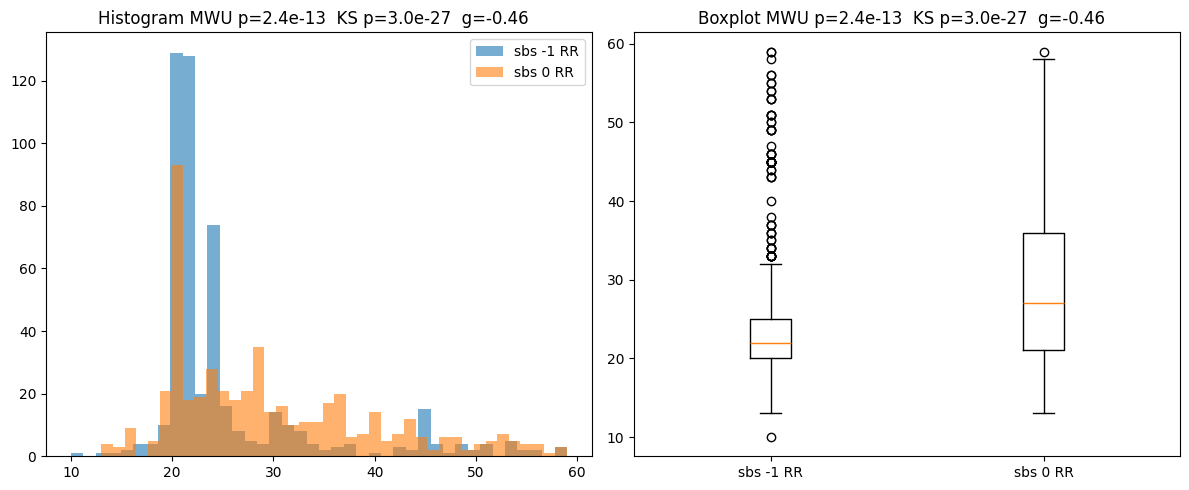

Significant differences found for sbs -1 RR vs sbs 1 RR:
  - Mann-Whitney U: p=4.136e-49
  - KS test: p=1.066e-56
  - Hedges' g: -0.967
  - Median diff: -13.000 (95% CI: [-14.000, -11.000])
  - P(Superiority): 0.233


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


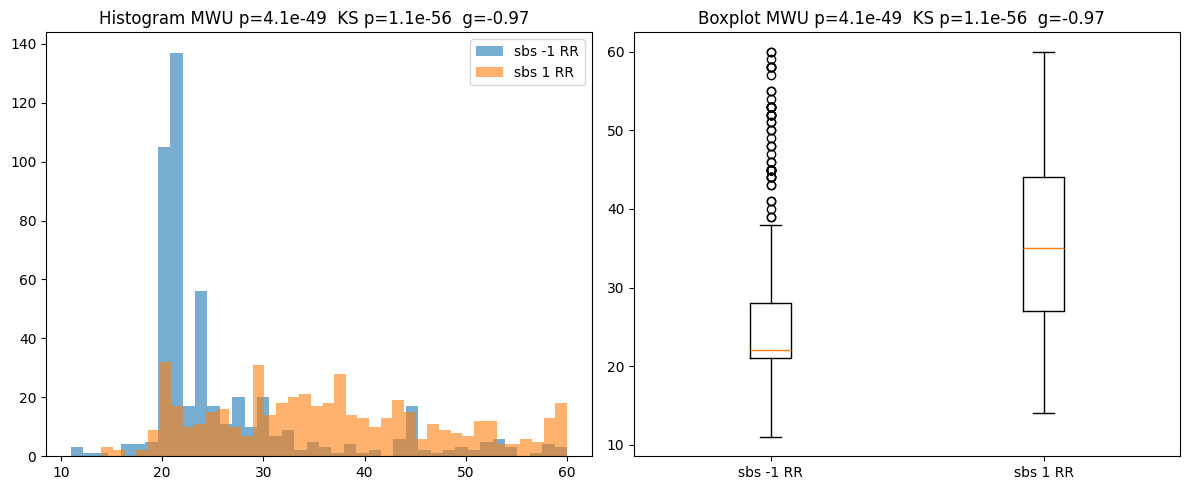

Significant differences found for sbs 0 RR vs sbs 1 RR:
  - Mann-Whitney U: p=6.575e-23
  - KS test: p=3.632e-17
  - Hedges' g: -0.648
  - Median diff: -9.000 (95% CI: [-10.000, -6.000])
  - P(Superiority): 0.318


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


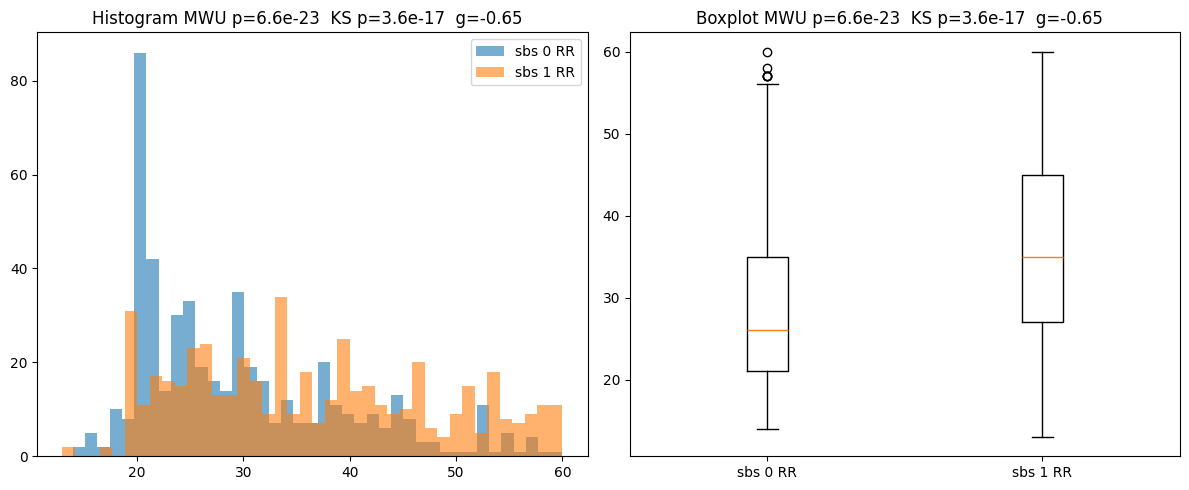

Significant differences found for sbs -2 Accel vs sbs -1 Accel:
  - KS test: p=4.950e-02
  - Median diff: -0.000 (95% CI: [-0.000, 0.000])
  - P(Superiority): 0.493


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


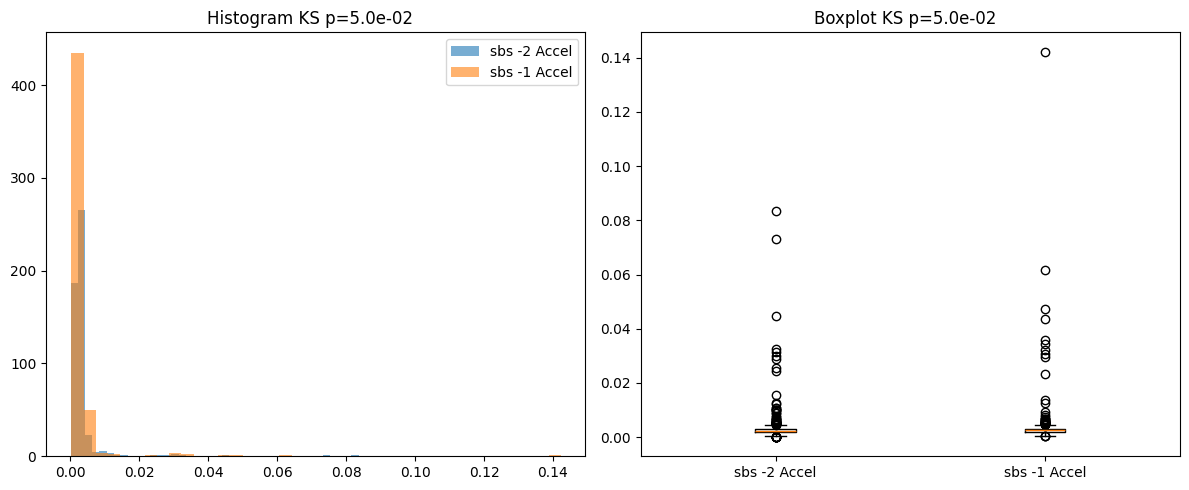

Significant differences found for sbs -2 Accel vs sbs 1 Accel:
  - KS test: p=5.497e-09
  - Median diff: 0.000 (95% CI: [-0.000, 0.000])
  - P(Superiority): 0.541


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


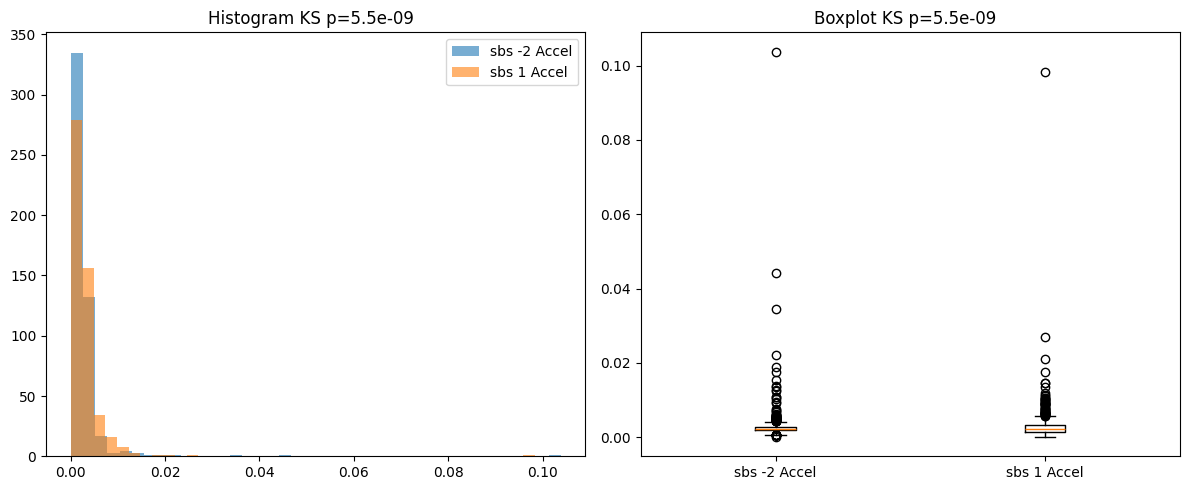

Significant differences found for sbs -1 Accel vs sbs 0 Accel:
  - KS test: p=1.989e-02
  - Median diff: -0.000 (95% CI: [-0.000, -0.000])
  - P(Superiority): 0.484


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


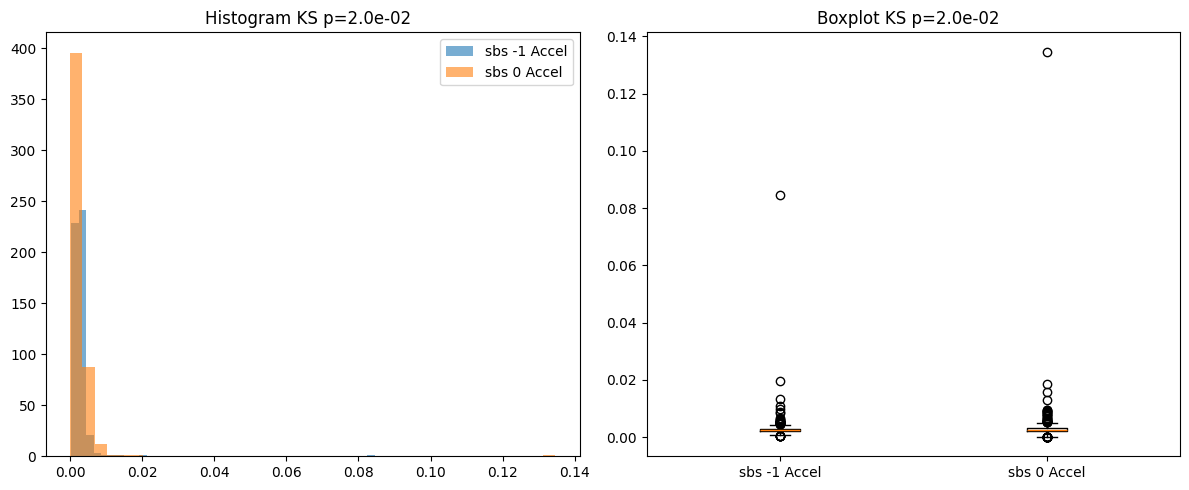

Significant differences found for sbs -1 Accel vs sbs 1 Accel:
  - Mann-Whitney U: p=1.215e-02
  - KS test: p=5.193e-11
  - Median diff: 0.000 (95% CI: [-0.000, 0.000])
  - P(Superiority): 0.546


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


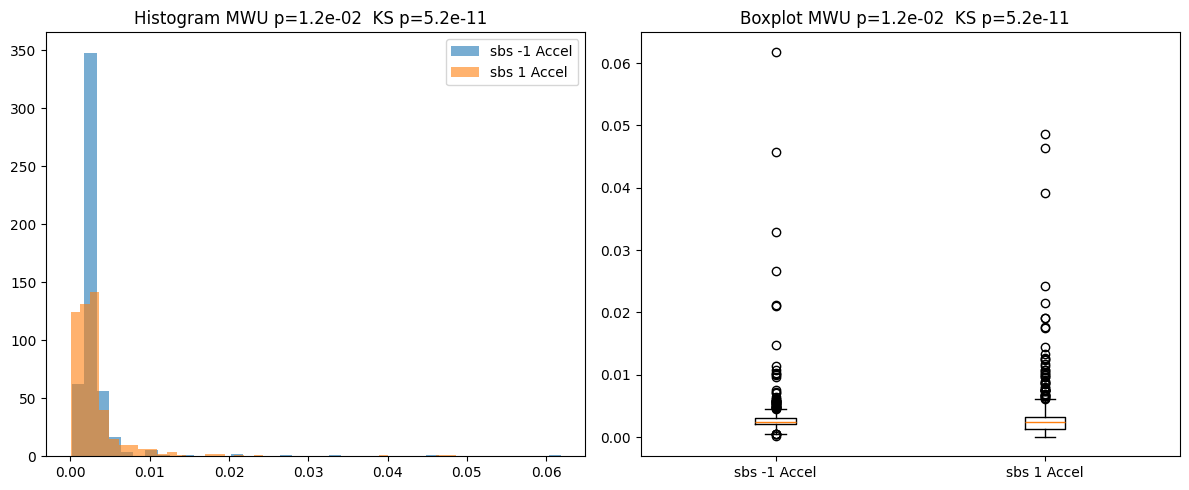

Significant differences found for sbs 0 Accel vs sbs 1 Accel:
  - KS test: p=2.755e-06
  - Median diff: -0.000 (95% CI: [-0.000, 0.000])
  - P(Superiority): 0.514


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


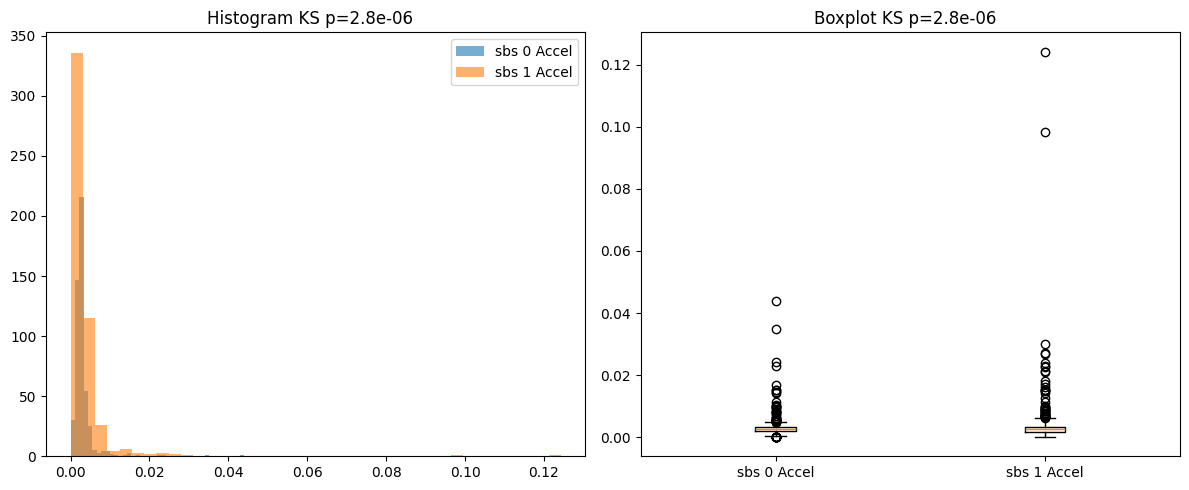

In [102]:
# Toggle between normalized and raw values
USE_NORMALIZED = False  # Set to True for normalized values, False for raw values

SBS_hr_dict = {-3: [], -2: [], -1: [], 0: [], 1: [], 2: []}
SBS_rr_dict = {-3: [], -2: [], -1: [], 0: [], 1: [], 2: []}
SBS_accel_dict = {-3: [], -2: [], -1: [], 0: [], 1: [], 2: []}

# all SBS keys
sbs_keys = [-3, -2, -1, 0, 1, 2]

# Define reasonable ranges for HR and RR (adjust these values as needed)
HR_MIN = 30   # minimum reasonable heart rate (bpm)
HR_MAX = 200  # maximum reasonable heart rate (bpm)
RR_MIN = 5    # minimum reasonable respiratory rate (breaths per minute)
RR_MAX = 60   # maximum reasonable respiratory rate (breaths per minute)

for patient in os.listdir(data_dir):
    # filter out non-directories
    patient_dir = os.path.join(data_dir, patient)
    if os.path.isdir(patient_dir):
        data_filepath = os.path.join(patient_dir, f'{patient}_SICKBAY_{lead_time}MIN_{slice_size_min - lead_time}MIN_{Tag}.mat')

        try:
            data = loadmat(data_filepath)
            x_mag = data["x_mag"]
            SBS = data["sbs"].flatten()
            
            hr = data['heart_rate']
            SpO2 = data['SpO2']
            rr = data['respiratory_rate']

            for i, sbs in enumerate(SBS):
                sbs = int(sbs)

                # extract raw arrays
                hr_data = hr[i].flatten()
                rr_data = rr[i].flatten()

                # Create masks for valid HR and RR values
                hr_valid_mask = (hr_data != 0) & (hr_data >= HR_MIN) & (hr_data <= HR_MAX) & ~np.isnan(hr_data)
                rr_valid_mask = (rr_data != 0) & (rr_data >= RR_MIN) & (rr_data <= RR_MAX) & ~np.isnan(rr_data)
                
                # Filter out invalid values
                hr_clean = hr_data[hr_valid_mask]
                rr_clean = rr_data[rr_valid_mask]

                # Skip if we don't have enough valid data points after cleaning
                if len(hr_clean) < 2 or len(rr_clean) < 2:
                    continue

                if USE_NORMALIZED:
                    # Normalize the cleaned data
                    hr_min, hr_max = hr_clean.min(), hr_clean.max()
                    # Skip if range is too small (might indicate bad data)
                    if (hr_max - hr_min) < 1:  # less than 1 bpm range
                        continue
                    hr_processed = (hr_clean - hr_min) / (hr_max - hr_min)

                    rr_min, rr_max = rr_clean.min(), rr_clean.max()
                    # Skip if range is too small (might indicate bad data)
                    if (rr_max - rr_min) < 0.5:  # less than 0.5 breaths/min range
                        continue
                    rr_processed = (rr_clean - rr_min) / (rr_max - rr_min)
                else:
                    # Use raw values (still cleaned of invalid values)
                    hr_processed = hr_clean
                    rr_processed = rr_clean

                mad = Actigraph_Metrics.VecMag_MAD(x_mag[i, :], window_size)
                mad = np.array(mad).flatten()
                
                if USE_NORMALIZED:
                    mad_min, mad_max = mad.min(), mad.max()
                    mad_processed = (mad - mad_min) / (mad_max - mad_min)
                else:
                    mad_processed = mad

                SBS_hr_dict[sbs].extend(hr_processed.tolist())
                SBS_rr_dict[sbs].extend(rr_processed.tolist())
                SBS_accel_dict[sbs].extend(mad_processed.tolist())

        except: 
            print(f'skipping patient {patient} due to load error.')
            continue
    
# metrics dicts
metrics = {
    "HR": SBS_hr_dict,
    "RR": SBS_rr_dict,
    "Accel": SBS_accel_dict
}

# iterate over all pairs of SBS keys
for metric_name, metric_dict in metrics.items():
    for sbs1, sbs2 in itertools.combinations(sbs_keys, 2):
        if sbs1 != sbs2:
            data1 = metric_dict[sbs1]
            data2 = metric_dict[sbs2]
            
            # Only perform comparison if we have sufficient data
            if len(data1) > 0 and len(data2) > 0:
                # call your compare_data function
                significant_differences = compare_data(
                    data1, f'sbs {sbs1} {metric_name}',
                    data2, f'sbs {sbs2} {metric_name}'
                )

In [105]:
#data_dir = 'C:/Users/sidha/OneDrive/Sid_stuff/PROJECTS/PedAccel/data_analysis/Vitals_accel_analysis/PatientData'
data_dir = Path('/Users/jakehoffmann/Documents/JHU_Research/DT 6 Sedation/Ventilated_Patient_Data')
data_dir = Path('/Users/jakehoffmann/Documents/JHU_Research/DT 6 Sedation/PatientData_Directory_To_Have_NEW 3')
window_size = 100 #100 is 1 second worth of time
lead_time = 1
slice_size_min = 16
sr = .5
Tag = 'Nurse'

Significant differences found for sbs -1 HR vs sbs 0 HR:
  - Mann-Whitney U: p=2.651e-02
  - KS test: p=1.434e-04
  - Hedges' g: -0.242
  - Median diff: 2.000 (95% CI: [-3.000, 5.000])
  - P(Superiority): 0.451


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


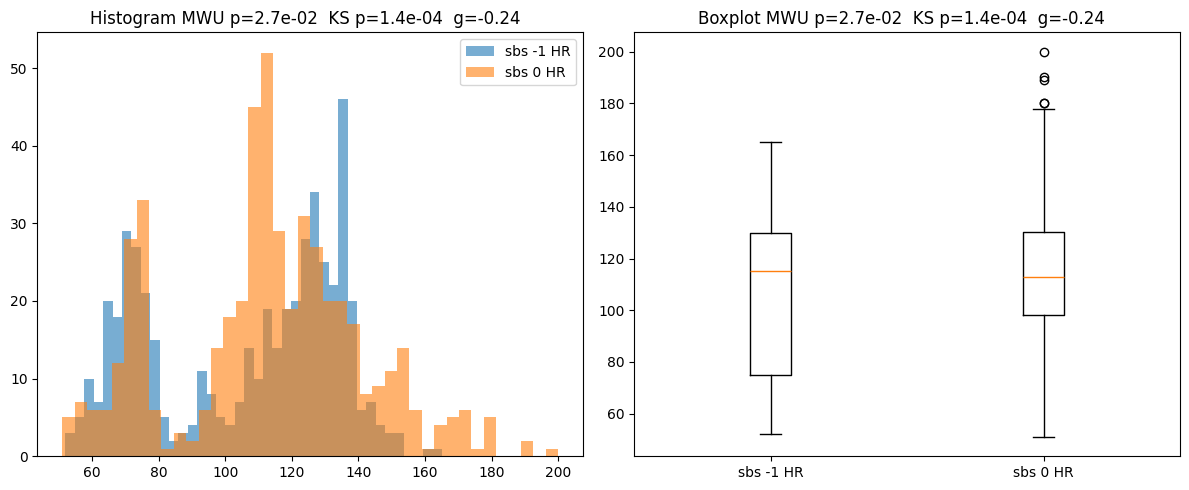

Significant differences found for sbs -1 HR vs sbs 1 HR:
  - Mann-Whitney U: p=2.198e-09
  - KS test: p=7.031e-10
  - Hedges' g: 0.381
  - Median diff: 25.000 (95% CI: [15.000, 33.000])
  - P(Superiority): 0.612


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


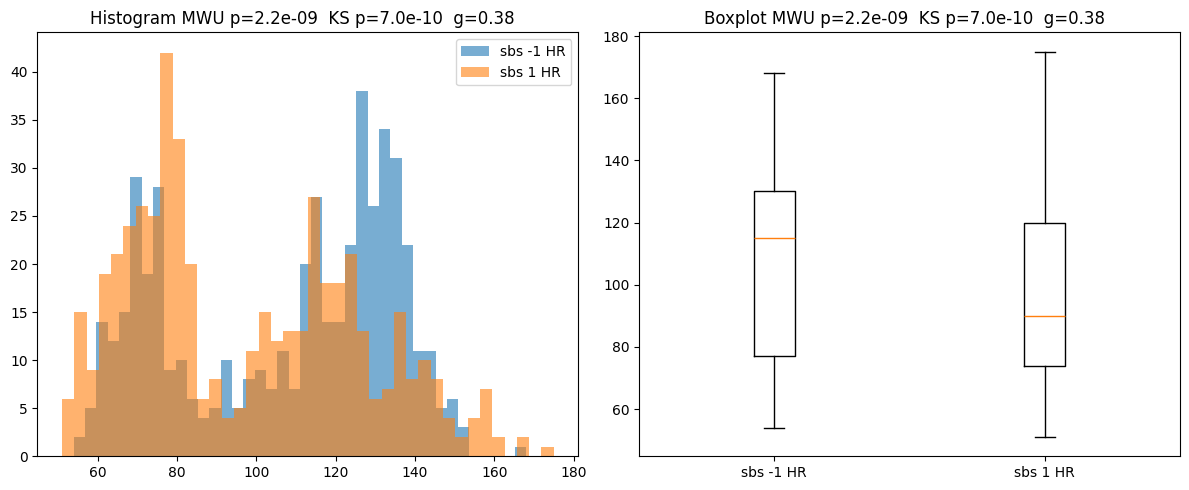

Significant differences found for sbs -1 HR vs sbs 2 HR:
  - Mann-Whitney U: p=1.822e-04
  - KS test: p=2.107e-11
  - Median diff: 18.000 (95% CI: [11.000, 22.000])
  - P(Superiority): 0.574


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


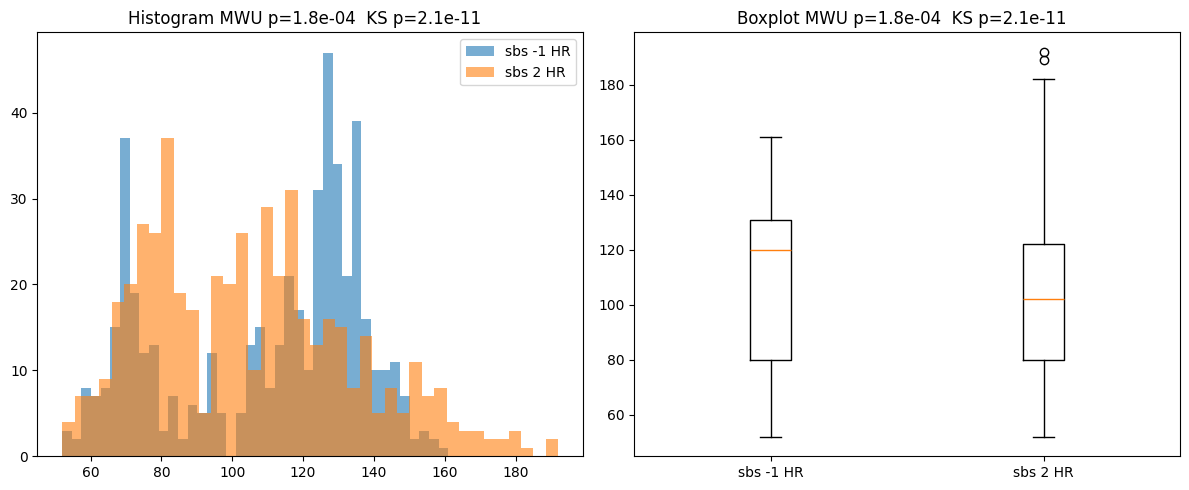

Significant differences found for sbs 0 HR vs sbs 1 HR:

/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])



  - Mann-Whitney U: p=5.291e-09
  - KS test: p=6.592e-14
  - Hedges' g: 0.432
  - Median diff: 13.000 (95% CI: [8.000, 25.500])
  - P(Superiority): 0.589


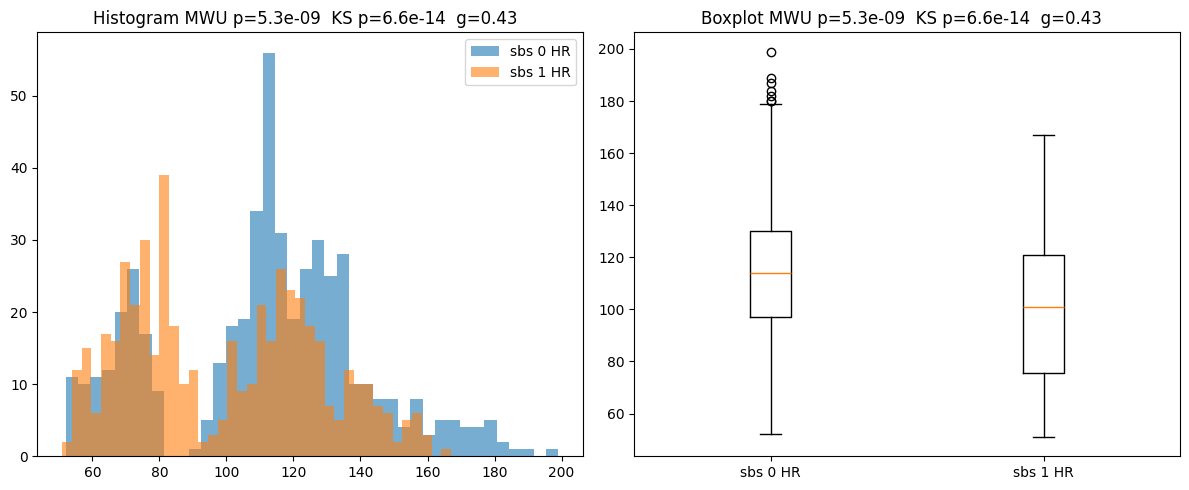

Significant differences found for sbs 0 HR vs sbs 2 HR:
  - Mann-Whitney U: p=1.880e-04
  - KS test: p=1.796e-08
  - Hedges' g: 0.213
  - Median diff: 8.500 (95% CI: [4.000, 14.000])
  - P(Superiority): 0.561


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


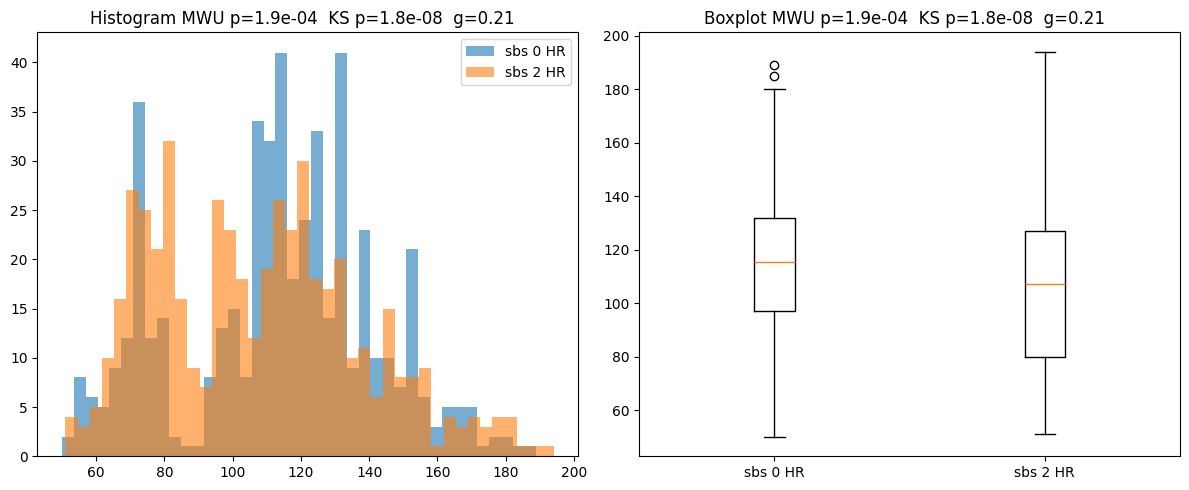

Significant differences found for sbs 1 HR vs sbs 2 HR:
  - Mann-Whitney U: p=1.270e-08
  - KS test: p=6.125e-05
  - Hedges' g: -0.388
  - Median diff: -10.000 (95% CI: [-21.500, -3.500])
  - P(Superiority): 0.395


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


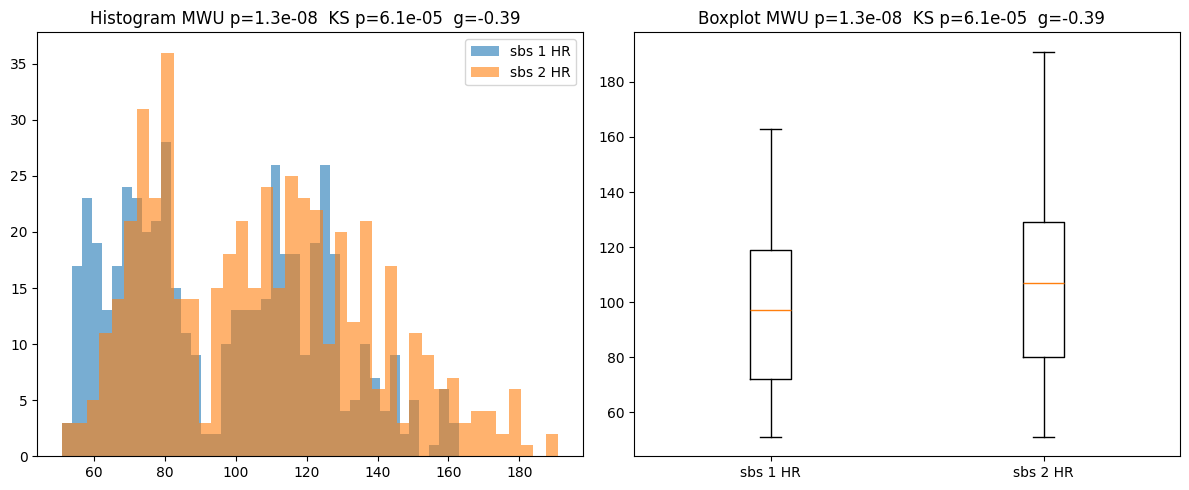

Significant differences found for sbs -1 RR vs sbs 0 RR:
  - Mann-Whitney U: p=4.671e-11
  - KS test: p=3.874e-08
  - Hedges' g: -0.462
  - Median diff: -4.000 (95% CI: [-6.000, -2.000])
  - P(Superiority): 0.339


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


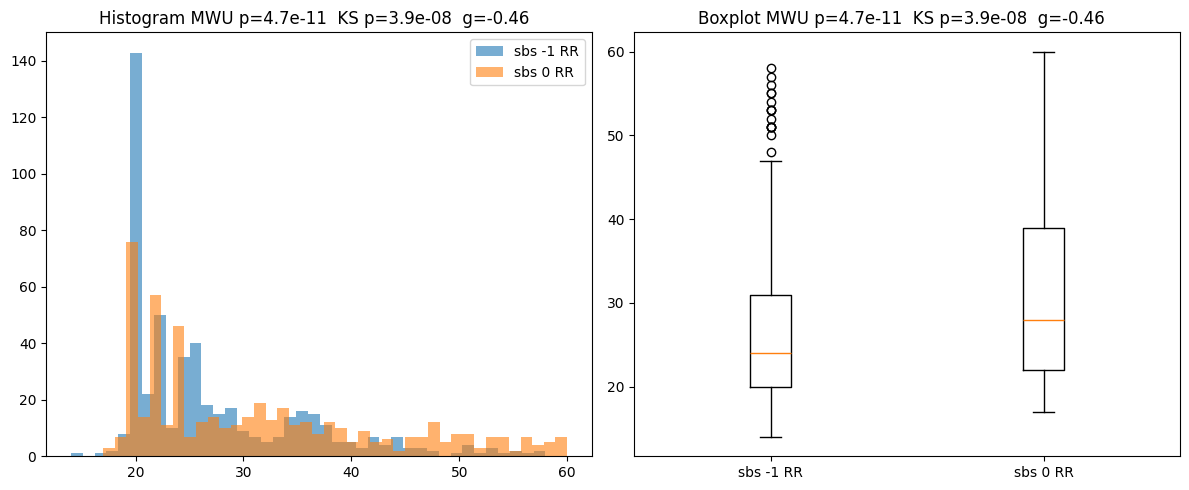

Significant differences found for sbs -1 RR vs sbs 1 RR:
  - KS test: p=2.900e-02
  - Median diff: 0.000 (95% CI: [-1.000, 1.000])
  - P(Superiority): 0.413


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


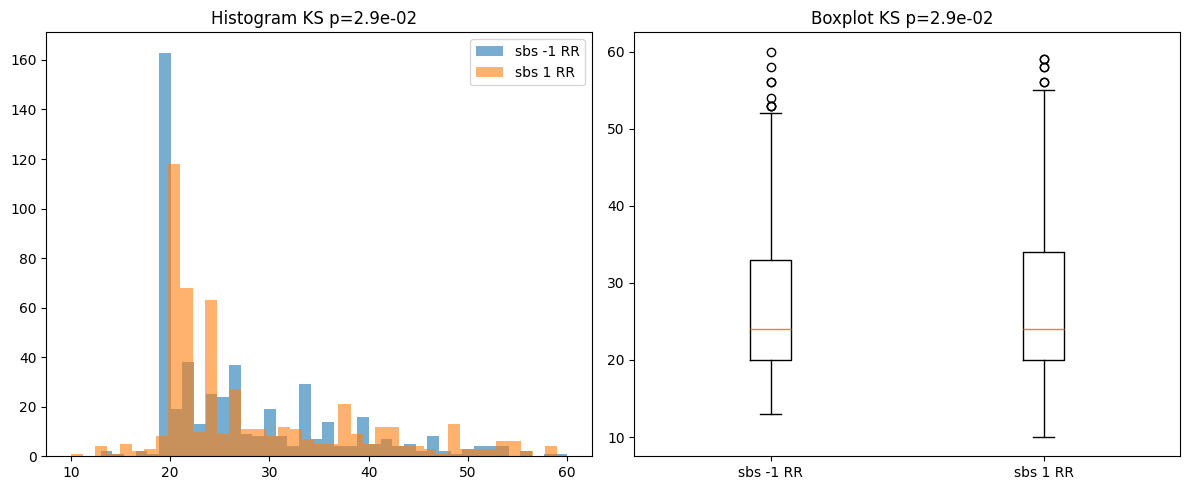

Significant differences found for sbs -1 RR vs sbs 2 RR:
  - KS test: p=3.751e-03
  - Median diff: 0.000 (95% CI: [-0.012, 2.000])
  - P(Superiority): 0.466


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


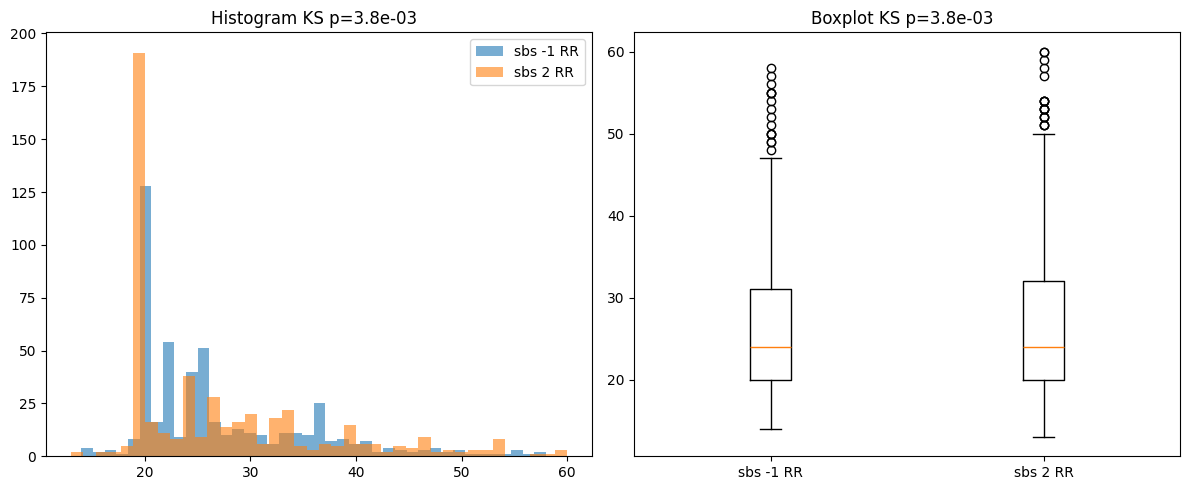

Significant differences found for sbs 0 RR vs sbs 1 RR:

/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])



  - Mann-Whitney U: p=3.671e-15
  - KS test: p=4.823e-13
  - Hedges' g: 0.512
  - Median diff: 6.000 (95% CI: [3.488, 8.000])
  - P(Superiority): 0.594


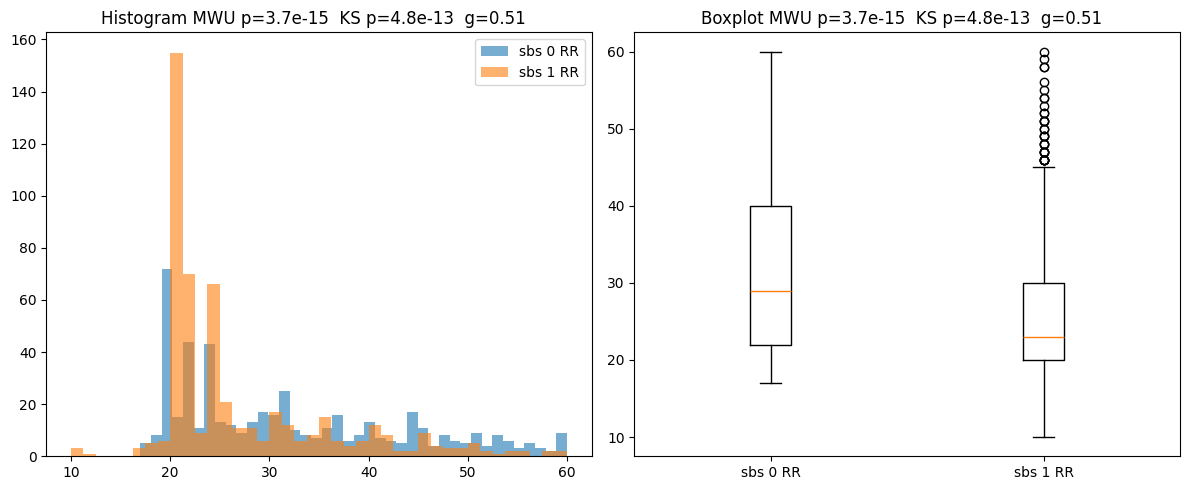

Significant differences found for sbs 0 RR vs sbs 2 RR:
  - Mann-Whitney U: p=6.573e-13
  - KS test: p=3.297e-12
  - Hedges' g: 0.422
  - Median diff: 4.000 (95% CI: [3.000, 7.000])
  - P(Superiority): 0.573


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


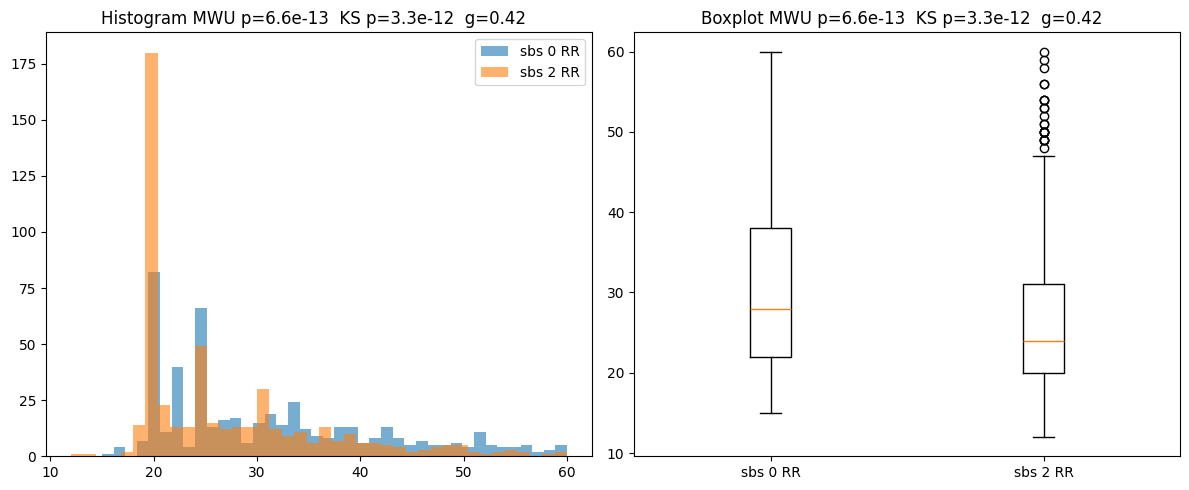

Significant differences found for sbs 0 Accel vs sbs 1 Accel:
  - Mann-Whitney U: p=1.146e-03
  - KS test: p=1.434e-04
  - Median diff: 0.000 (95% CI: [0.000, 0.000])
  - P(Superiority): 0.569


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


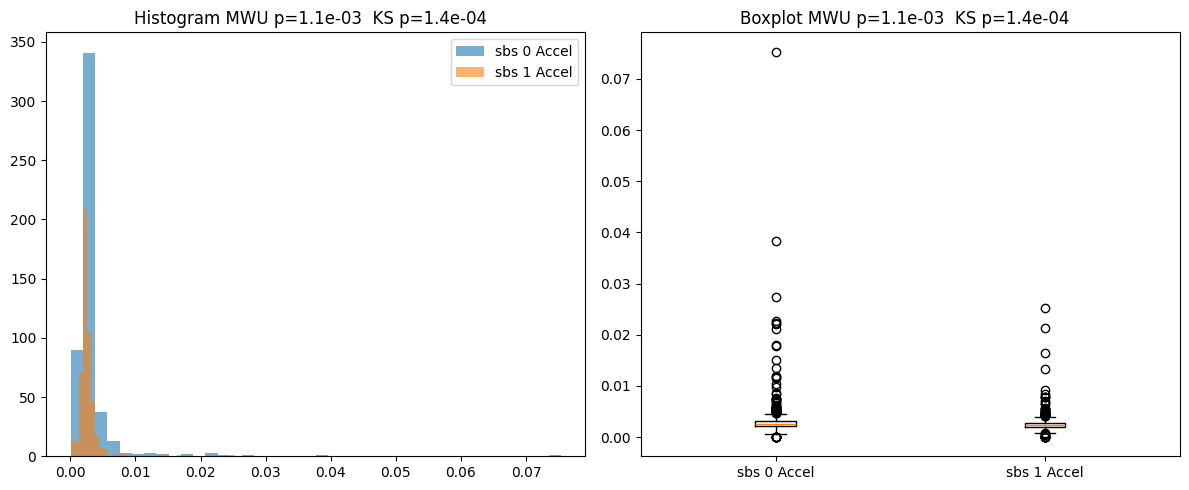

Significant differences found for sbs 1 Accel vs sbs 2 Accel:
  - KS test: p=5.832e-03
  - Median diff: -0.000 (95% CI: [-0.000, 0.000])
  - P(Superiority): 0.478


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1340292504.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


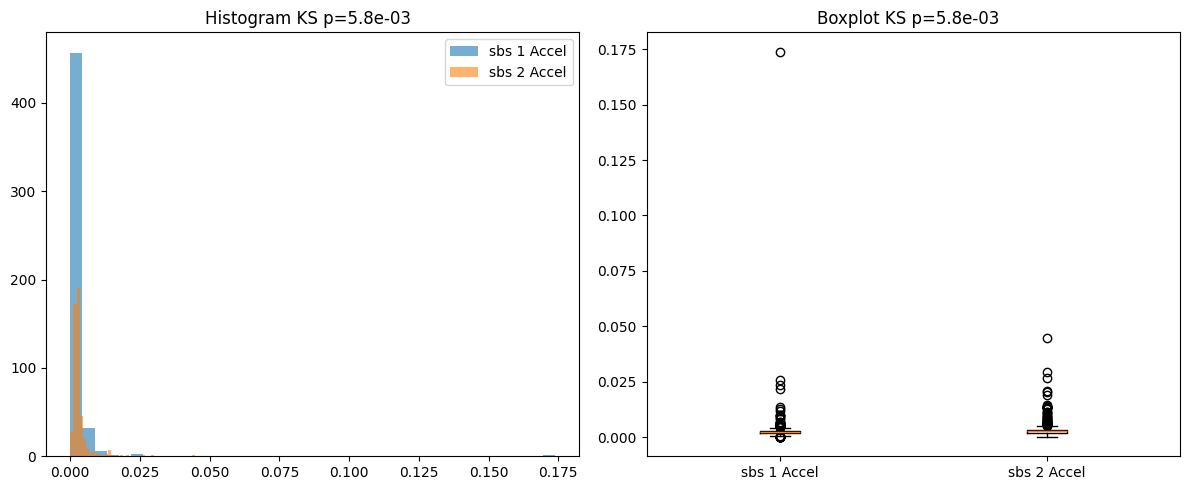

In [107]:
# Toggle between normalized and raw values
USE_NORMALIZED = False  # Set to True for normalized values, False for raw values

SBS_hr_dict = {-3: [], -2: [], -1: [], 0: [], 1: [], 2: []}
SBS_rr_dict = {-3: [], -2: [], -1: [], 0: [], 1: [], 2: []}
SBS_accel_dict = {-3: [], -2: [], -1: [], 0: [], 1: [], 2: []}

# all SBS keys
sbs_keys = [-3, -2, -1, 0, 1, 2]

# Define reasonable ranges for HR and RR (adjust these values as needed)
HR_MIN = 30   # minimum reasonable heart rate (bpm)
HR_MAX = 200  # maximum reasonable heart rate (bpm)
RR_MIN = 5    # minimum reasonable respiratory rate (breaths per minute)
RR_MAX = 60   # maximum reasonable respiratory rate (breaths per minute)

for patient in os.listdir(data_dir):
    # filter out non-directories
    patient_dir = os.path.join(data_dir, patient)
    if os.path.isdir(patient_dir):
        data_filepath = os.path.join(patient_dir, f'{patient}_SICKBAY_{slice_size_min - lead_time}MIN_{lead_time}MIN{Tag}.mat')

        try:
            data = loadmat(data_filepath)
            x_mag = data["x_mag"]
            SBS = data["sbs"].flatten()
            
            hr = data['heart_rate']
            SpO2 = data['SpO2']
            rr = data['respiratory_rate']

            for i, sbs in enumerate(SBS):
                sbs = int(sbs)

                # extract raw arrays
                hr_data = hr[i].flatten()
                rr_data = rr[i].flatten()

                # Create masks for valid HR and RR values
                hr_valid_mask = (hr_data != 0) & (hr_data >= HR_MIN) & (hr_data <= HR_MAX) & ~np.isnan(hr_data)
                rr_valid_mask = (rr_data != 0) & (rr_data >= RR_MIN) & (rr_data <= RR_MAX) & ~np.isnan(rr_data)
                
                # Filter out invalid values
                hr_clean = hr_data[hr_valid_mask]
                rr_clean = rr_data[rr_valid_mask]

                # Skip if we don't have enough valid data points after cleaning
                if len(hr_clean) < 2 or len(rr_clean) < 2:
                    continue

                if USE_NORMALIZED:
                    # Normalize the cleaned data
                    hr_min, hr_max = hr_clean.min(), hr_clean.max()
                    # Skip if range is too small (might indicate bad data)
                    if (hr_max - hr_min) < 1:  # less than 1 bpm range
                        continue
                    hr_processed = (hr_clean - hr_min) / (hr_max - hr_min)

                    rr_min, rr_max = rr_clean.min(), rr_clean.max()
                    # Skip if range is too small (might indicate bad data)
                    if (rr_max - rr_min) < 0.5:  # less than 0.5 breaths/min range
                        continue
                    rr_processed = (rr_clean - rr_min) / (rr_max - rr_min)
                else:
                    # Use raw values (still cleaned of invalid values)
                    hr_processed = hr_clean
                    rr_processed = rr_clean

                mad = Actigraph_Metrics.VecMag_MAD(x_mag[i, :], window_size)
                mad = np.array(mad).flatten()
                
                if USE_NORMALIZED:
                    mad_min, mad_max = mad.min(), mad.max()
                    mad_processed = (mad - mad_min) / (mad_max - mad_min)
                else:
                    mad_processed = mad

                SBS_hr_dict[sbs].extend(hr_processed.tolist())
                SBS_rr_dict[sbs].extend(rr_processed.tolist())
                SBS_accel_dict[sbs].extend(mad_processed.tolist())

        except: 
            print(f'skipping patient {patient} due to load error.')
            continue
    
# metrics dicts
metrics = {
    "HR": SBS_hr_dict,
    "RR": SBS_rr_dict,
    "Accel": SBS_accel_dict
}

# iterate over all pairs of SBS keys
for metric_name, metric_dict in metrics.items():
    for sbs1, sbs2 in itertools.combinations(sbs_keys, 2):
        if sbs1 != sbs2:
            data1 = metric_dict[sbs1]
            data2 = metric_dict[sbs2]
            
            # Only perform comparison if we have sufficient data
            if len(data1) > 0 and len(data2) > 0:
                # call your compare_data function
                significant_differences = compare_data(
                    data1, f'sbs {sbs1} {metric_name}',
                    data2, f'sbs {sbs2} {metric_name}'
                )